**Tranfer Learning VGG16**

In [286]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import math
import datetime, os
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, GlobalAveragePooling2D, ReLU, Dropout, Conv2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from PIL import Image

In [287]:
inputShape=[224,224]
pp = imagenet_utils.preprocess_input

In [288]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [289]:
model = VGG16(weights='imagenet', include_top=True)

**Without changes on model**

In [290]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [291]:
img = load_img('/content/drive/MyDrive/ML DL/Dataset/61FMbYqZVxL._SY355_.jpg', target_size=[224,224])

In [292]:
img = img_to_array(img)

In [293]:
img = np.expand_dims(img,axis=0)

In [294]:
img = pp(img)

In [295]:
pred = model.predict(img)

In [296]:
pd = imagenet_utils.decode_predictions(pred)

**VGG16 got it right.Image is Bike**

In [297]:
pd

[[('n03791053', 'motor_scooter', 0.6460704),
  ('n03127747', 'crash_helmet', 0.17391385),
  ('n03785016', 'moped', 0.09252021),
  ('n04252077', 'snowmobile', 0.04214033),
  ('n03208938', 'disk_brake', 0.010791912)]]

**VGG16 got it wrong.Image is orange**

In [298]:
img = load_img('/content/drive/MyDrive/ML DL/Dataset/Fruit_Dataset/orange/orange_11.jpg', target_size=[224,224])
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
img = pp(img)
pred = model.predict(img)
pd = imagenet_utils.decode_predictions(pred)
pd

[[('n03942813', 'ping-pong_ball', 0.8638991),
  ('n02782093', 'balloon', 0.014512734),
  ('n04409515', 'tennis_ball', 0.010805311),
  ('n02948072', 'candle', 0.010735885),
  ('n03134739', 'croquet_ball', 0.010644285)]]

**Training Phrase**

In [299]:
model = VGG16(weights='imagenet', include_top=False, input_shape=[224,224,3])

In [300]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Freezing the layer**

In [301]:
for layer in model.layers:
  layer.trainable = False

In [302]:
train_path = '/content/drive/MyDrive/ML DL/Dataset/Fruit_Dataset/Transfer Learning/train_set'
test_path = '/content/drive/MyDrive/ML DL/Dataset/Fruit_Dataset/Transfer Learning/test_set'

In [303]:
inr = Input(shape=(224,224,3))
out = model(inr)
s = Flatten()(out)
s = Dense(64,activation="relu")(s)
s = Dense(4,activation="softmax")(s)
model = Model(inputs=inr,outputs=s)

model.summary()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                1605696   
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 260       
Total params: 16,320,644
Trainable params: 1,605,956
Non-trainable params: 14,714,688
_________________________________________________________________


In [304]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [305]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [306]:
dgen = ImageDataGenerator(rescale=1./255,validation_split = 0.2, rotation_range = 60, 
                              shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_dgen = ImageDataGenerator(rescale=1./255)
train_batches = dgen.flow_from_directory(directory = train_path, target_size = (224,224), 
                                             batch_size = 10, subset = 'training', class_mode = 'categorical',
                                              shuffle = True)
validation_batches = dgen.flow_from_directory(directory = train_path, target_size = (224,224), 
                                             batch_size = 10, class_mode = 'categorical', subset = 'validation',
                                             shuffle = False)
test_batches = test_dgen.flow_from_directory(directory = test_path, target_size = (224,224), 
                                             batch_size = 2, class_mode = 'categorical')

Found 210 images belonging to 4 classes.
Found 51 images belonging to 4 classes.
Found 39 images belonging to 4 classes.


In [307]:
x_train, y_train = next(train_batches)
xvalid,yvalid = next(validation_batches)

In [308]:
print('x_train: ',type(x_train))
print('y_train: ', type(y_train))
print('x-shape: ', x_train.shape)
print('y-shape: ', y_train.shape)

x_train:  <class 'numpy.ndarray'>
y_train:  <class 'numpy.ndarray'>
x-shape:  (10, 224, 224, 3)
y-shape:  (10, 4)


In [309]:
t_layer = len(model.layers)
print (t_layer)

5


**Training**

In [310]:
history = model.fit_generator(train_batches, epochs=5, validation_data=validation_batches)

print('Training Completed')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
 6/21 [=======>......................] - ETA: 1:18 - loss: 1.9429 - accuracy: 0.3500

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/21 [==============================] - 138s 7s/step - loss: 0.8975 - accuracy: 0.4905 - val_loss: 0.3977 - val_accuracy: 0.5490
Epoch 2/5
21/21 [==============================] - 137s 7s/step - loss: 0.4193 - accuracy: 0.6048 - val_loss: 0.3418 - val_accuracy: 0.7647
Epoch 3/5
21/21 [==============================] - 141s 7s/step - loss: 0.3267 - accuracy: 0.7476 - val_loss: 0.3627 - val_accuracy: 0.6863
Epoch 4/5
21/21 [==============================] - 136s 7s/step - loss: 0.2718 - accuracy: 0.8048 - val_loss: 0.2990 - val_accuracy: 0.7059
Epoch 5/5
21/21 [==============================] - 136s 7s/step - loss: 0.2612 - accuracy: 0.7810 - val_loss: 0.2801 - val_accuracy: 0.7451
Training Completed


In [315]:
#%tensorboard --logdir logs/fit
model.save("Fruits_TranferLearning.h5")

**Results**

In [312]:
print("Orange = 3 \n Mixed = 2 \nBanana = 1 \n Apple = 0" )

Orange = 3 
 Mixed = 2 
Banana = 1 
 Apple = 0


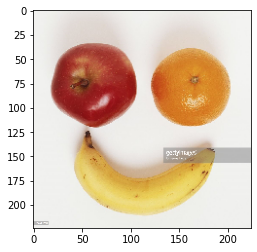

[2]


In [313]:
image = load_img("/content/drive/MyDrive/ML DL/Dataset/Fruit_Dataset/mixed/mixed_5.jpg", target_size=(224,224))
plt.imshow(image)
plt.show()
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
res = model.predict(image)
print(np.argmax(res,axis=1))

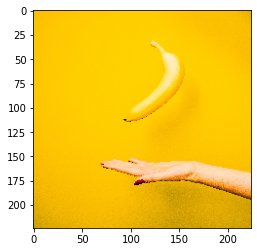

[1]


In [314]:
image = load_img("/content/drive/MyDrive/ML DL/Dataset/Fruit_Dataset/banana/banana_9.jpg", target_size=(224,224))
plt.imshow(image)
plt.show()
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
res = model.predict(image)
print(np.argmax(res,axis=1))